In [1]:
!pip install tensorflow
!pip install keras scikit_learn

# **Sales Revenue and Volume Forecasting Model**

## **Sales Revenue and Volume Forecasting model overview**


*   The  model uses online Retail Data from UC Irvine Machine Learning Repository
Online Retail - UCI Machine Learning Repository
*  Link to the data source https://archive.ics.uci.edu/dataset/352/online+retail

*   This data set contains all 541909 transactions between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online global retail company.
*   In this model we used LSTM models (Long Short Term Memory) to develop forecasting for sales revenue and sales volume
*   We used hyperparamter tuning to find the optimal LSTM models that produced the forecast with the least RMSE
*   The model takes around 30 minutes to run, primarily to search for optimal parameters for LSTM




The following cell consists of all the imported libraries for this model

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from warnings import filterwarnings
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

filterwarnings('ignore')



**Setting the random seed**

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## **Loading the data**

**This cell of the code is only applicable if you are using Colabs and Google Drive**

If you are not using Google Drive to load the data then comment the code in this cell.
If you are using Goolge Drive to load the data then "update" the drive location to the folder name where you have the data saved



In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SalesForecastingProject

Mounted at /content/drive
/content/drive/MyDrive/SalesForecastingProject


**File path for the data file**

Please update the filepath for the OnlineRetail data file

In [5]:
filepath="data/OnlineRetail.xlsx"

**Loading and initial profiling of the data**

In [6]:
online_retail_data = pd.read_excel(filepath)
online_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
online_retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
null_counts = online_retail_data.isna().sum()
print(null_counts)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## **Feature Engineering of data**


*   Convert the InvoiceDate timestamp to a datetime object
*   Create "FullDate" feature that only has the data
*   Create "Year" feature that only has the year for the Invoice
*   Create "Month" feature that only has the month for the Invoice
*   Create "YearMonth" feature that has the Year and Month for the Invoice
*   Create "DayOfWeek" feature that has the Day of the week for the Invoice
*   Create "SalesDollars" feature that is unit price of the item multiplied by the quantity










In [9]:
online_retail_data['InvoiceDate'] = pd.to_datetime(online_retail_data['InvoiceDate'])

In [10]:
online_retail_data['FullDate'] = online_retail_data['InvoiceDate'].dt.date
online_retail_data['Year'] = online_retail_data['InvoiceDate'].dt.year
online_retail_data['Month'] = online_retail_data['InvoiceDate'].dt.month
online_retail_data['YearMonth'] = online_retail_data['InvoiceDate'].dt.strftime('%Y-%m')
online_retail_data['DayOfWeek'] = online_retail_data['InvoiceDate'].dt.day_name()

In [11]:
online_retail_data['SalesDollars'] = online_retail_data['Quantity'] * online_retail_data['UnitPrice']

In [12]:
online_retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullDate,Year,Month,YearMonth,DayOfWeek,SalesDollars
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,20.34


In [13]:
online_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     541909 non-null  object        
 1   StockCode     541909 non-null  object        
 2   Description   540455 non-null  object        
 3   Quantity      541909 non-null  int64         
 4   InvoiceDate   541909 non-null  datetime64[ns]
 5   UnitPrice     541909 non-null  float64       
 6   CustomerID    406829 non-null  float64       
 7   Country       541909 non-null  object        
 8   FullDate      541909 non-null  object        
 9   Year          541909 non-null  int32         
 10  Month         541909 non-null  int32         
 11  YearMonth     541909 non-null  object        
 12  DayOfWeek     541909 non-null  object        
 13  SalesDollars  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(2), int64(1), object(7)
memo

## **Data profling and visualization**

## **Time series profiling of sales revenues versus date**

**Key findings**

*   Total sales revenue is **$9.74M**
*   Overall trend of sales revenues has a positive trajectory over time - especially over the last 100 days
*   Sales revenues has seasonality, there is strong seasonality every 30 days, some seasonality every 90 days (weakens after 30 days), and weak to no seasonality on a weekly basis


**Approach**

*   Grouped the data by sales revenues and date (full date)
*   Visualized the variation of sales revenues with date
*   Decomposed time series data to extract trend, seasonality and noise
*   To interpret seasonality, generated ACF plots with 7, 30 and 90 day lages

In [14]:
salesdollars_by_date = online_retail_data.groupby(['FullDate'])['SalesDollars'].sum().reset_index()

In [15]:
total_sales = salesdollars_by_date['SalesDollars'].sum()
print(f"Total Revenues: {total_sales}")

Total Revenues: 9747747.934


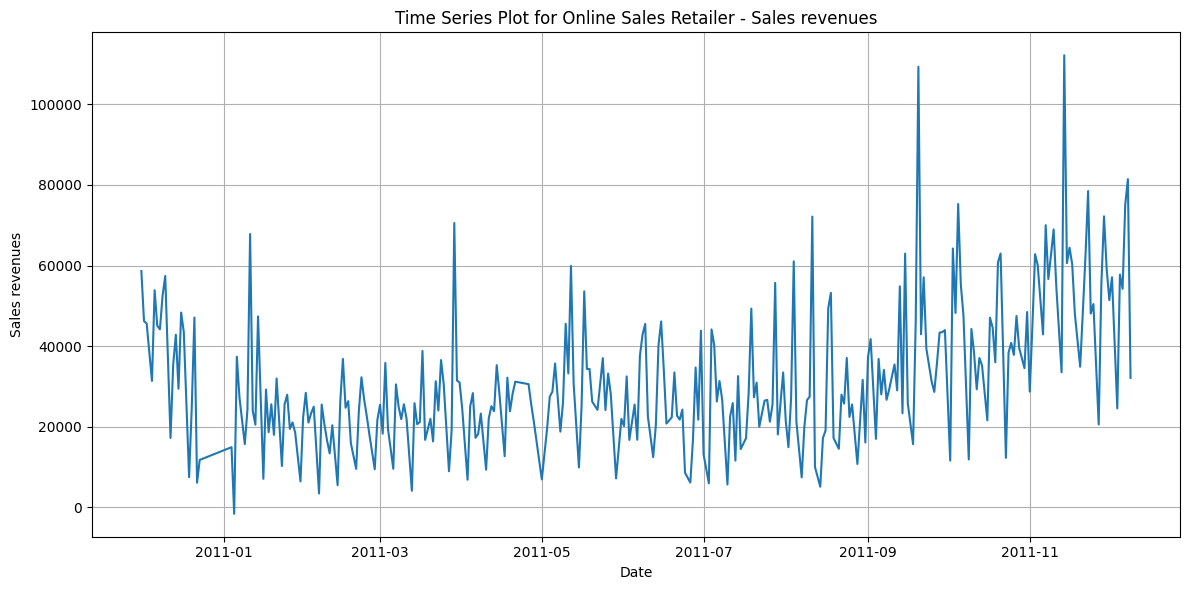

In [16]:
# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(salesdollars_by_date['FullDate'], salesdollars_by_date['SalesDollars'])
plt.xlabel('Date')
plt.ylabel('Sales revenues')
plt.title(f'Time Series Plot for Online Sales Retailer - Sales revenues')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Decompose the time series
decomposition_sales = seasonal_decompose(salesdollars_by_date['SalesDollars'], model='additive', period=30)  # Adjust period if needed

# Access the components
trend_sales = decomposition_sales.trend
seasonal_sales = decomposition_sales.seasonal
residual_sales = decomposition_sales.resid


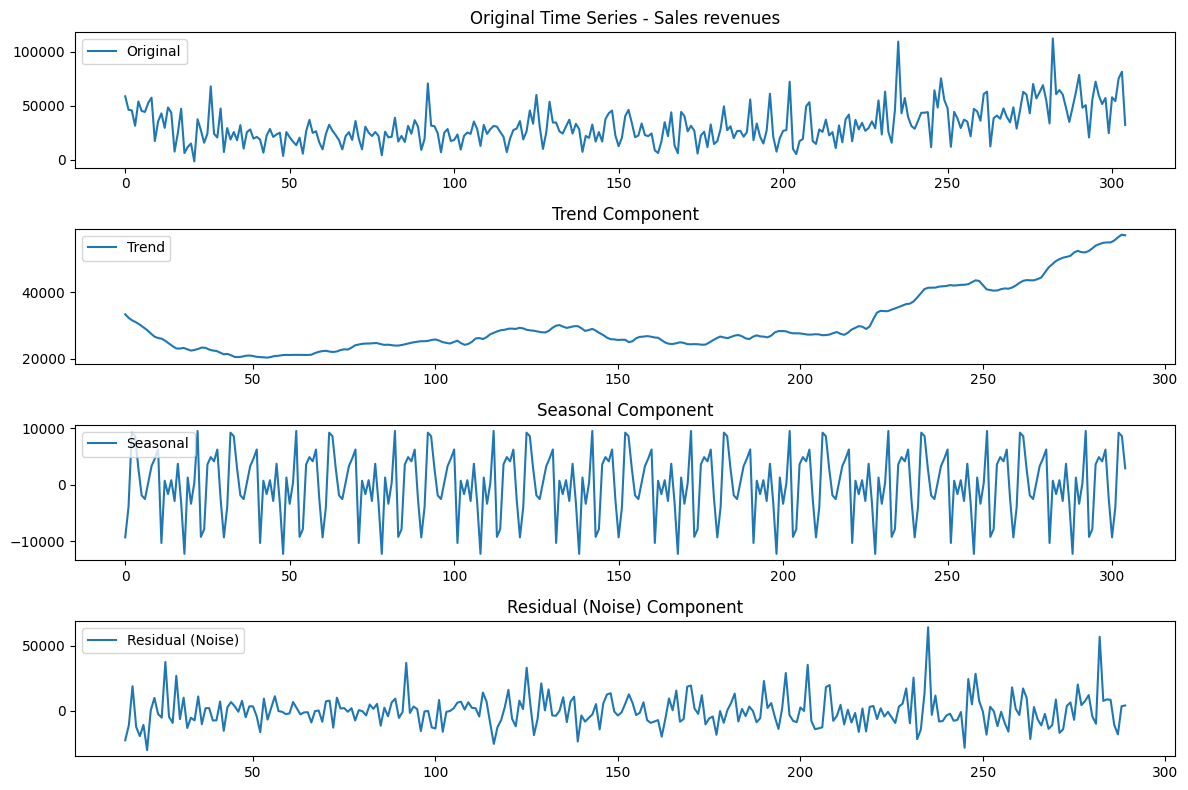

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(salesdollars_by_date['SalesDollars'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series - Sales revenues')

plt.subplot(412)
plt.plot(trend_sales, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal_sales, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual_sales, label='Residual (Noise)')
plt.legend(loc='upper left')
plt.title('Residual (Noise) Component')

plt.tight_layout()
plt.show()

### **ACF Plots for Seasonality of Sales Revenues**

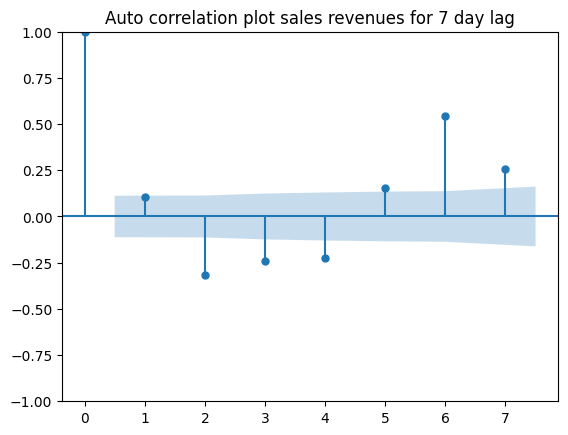

In [19]:
plot_acf(seasonal_sales, lags=7)  # Adjust lags as needed
plt.title(f'Auto correlation plot sales revenues for 7 day lag')
plt.show()

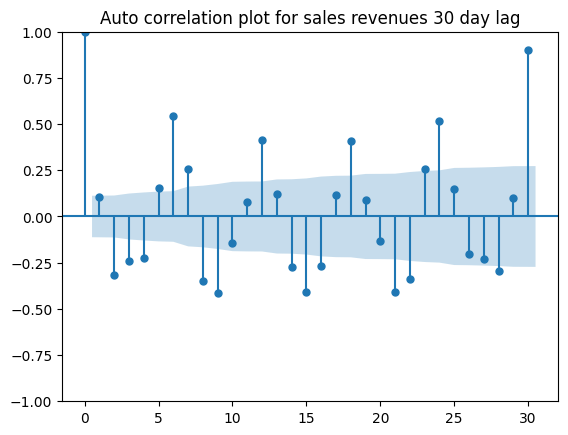

In [20]:
plot_acf(seasonal_sales, lags=30)  # Adjust lags as needed
plt.title(f'Auto correlation plot for sales revenues 30 day lag')
plt.show()

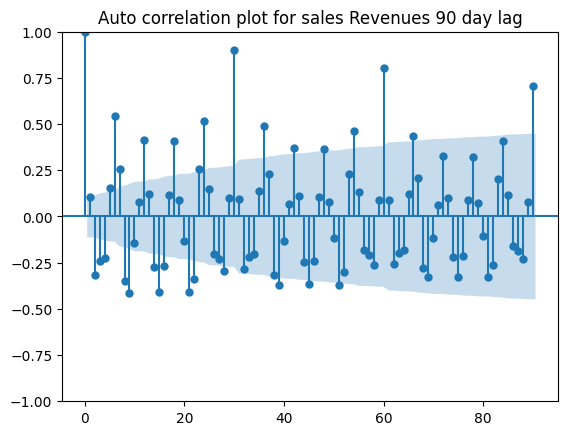

In [21]:
plot_acf(seasonal_sales, lags=90)  # Adjust lags as needed
plt.title(f'Auto correlation plot for sales Revenues 90 day lag')
plt.show()

## **Time series profiling of sales volume versus date**

**Key findings**


*   Total Sales Volume is **5.17M**
*   Overall trend of sales volume has a positive trajectory over time - especially over the last 150 days
*   Sales volume has seasonality, there is strong seasonality every 30 days, some seasonality every 90 days, and weak to no seasonality on a weekly basis


**Approach**

*   Grouped the data by quantity and date (full date)
*   Visualized the variation of sales volume with date
*   Decomposed time series data to extract trend, seasonality and noise
*   To interpret seasonality, generated ACF plots with 7, 30 and 90 day lages





In [22]:
salesquantity_by_date = online_retail_data.groupby(['FullDate'])['Quantity'].sum().reset_index()

In [23]:
total_quantity = salesquantity_by_date['Quantity'].sum()
print(f"Total Quantity: {total_quantity}")

Total Quantity: 5176450


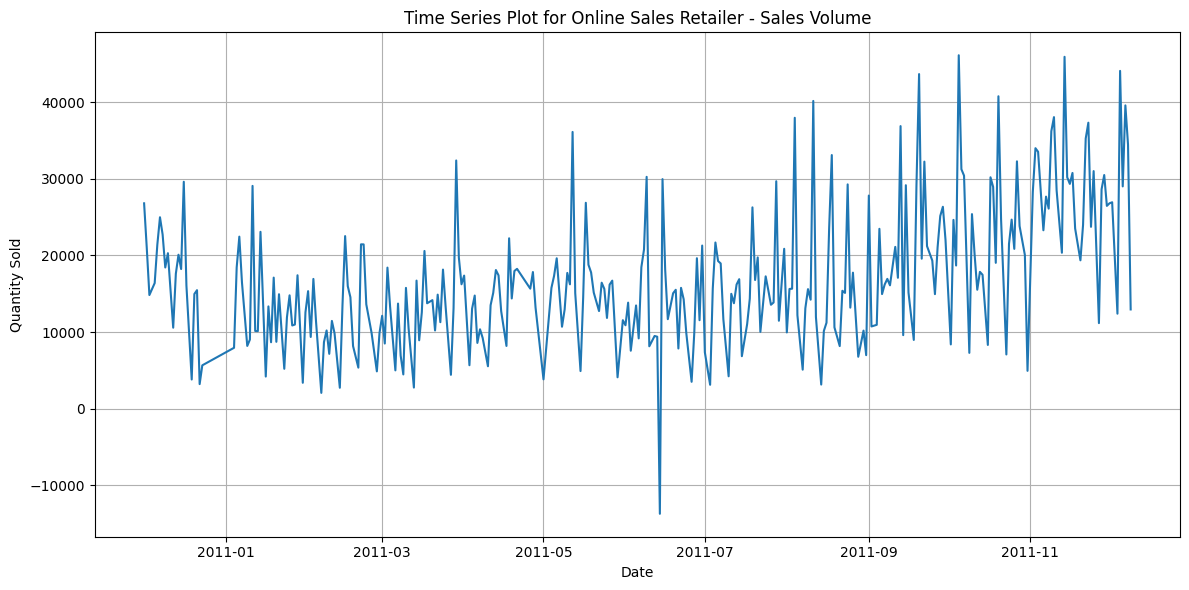

In [24]:
# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(salesquantity_by_date['FullDate'], salesquantity_by_date['Quantity'])
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title(f'Time Series Plot for Online Sales Retailer - Sales Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
decomposition_quantity = seasonal_decompose(salesquantity_by_date['Quantity'], model='additive', period=30)  # Adjust period if needed

# Access the components
trend_quantity = decomposition_quantity.trend
seasonal_quantity = decomposition_quantity.seasonal
residual_quantity = decomposition_quantity.resid


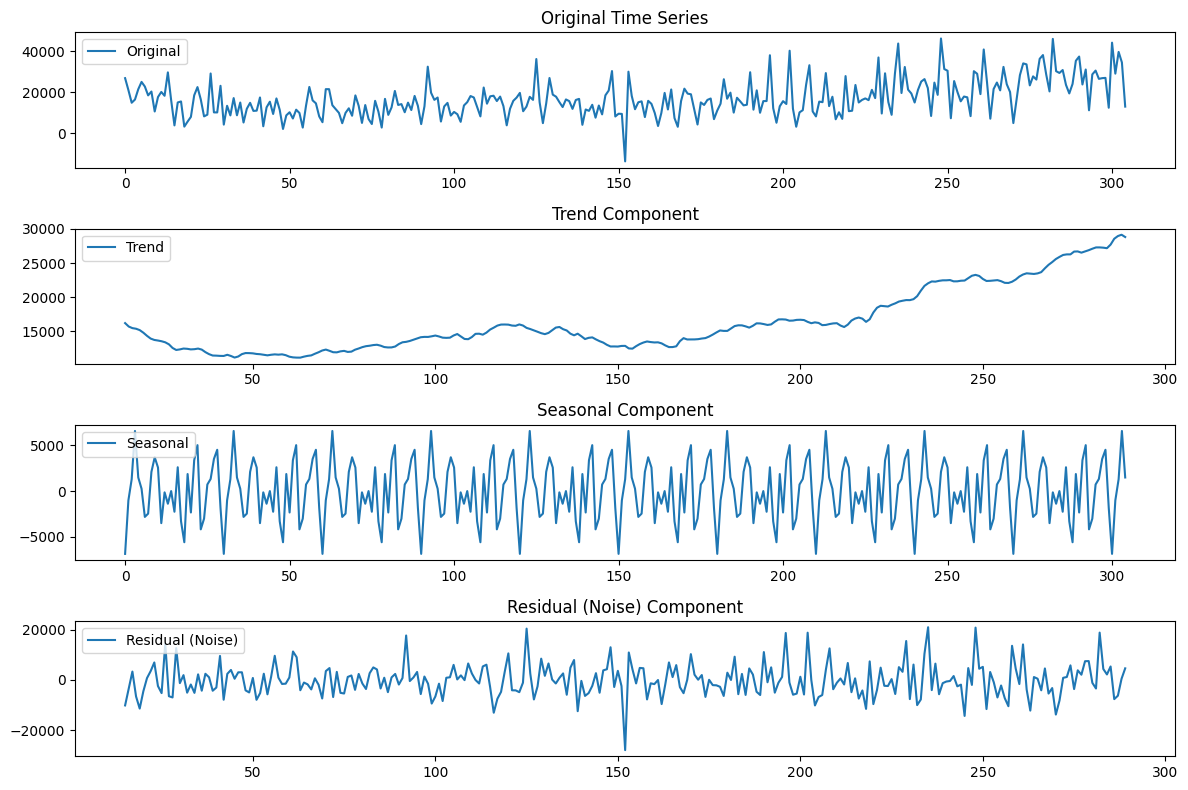

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(salesquantity_by_date['Quantity'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(trend_quantity, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal_quantity, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual_quantity, label='Residual (Noise)')
plt.legend(loc='upper left')
plt.title('Residual (Noise) Component')

plt.tight_layout()
plt.show()

### **ACF Plots for Seasonality of Sales Volume**

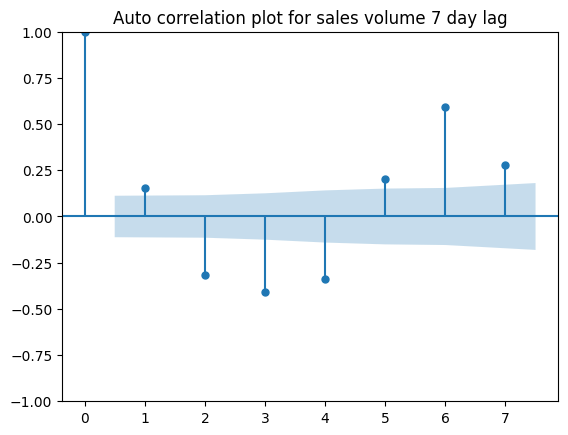

In [27]:
plot_acf(seasonal_quantity, lags=7)  # Adjust lags as needed
plt.title(f'Auto correlation plot for sales volume 7 day lag')
plt.show()

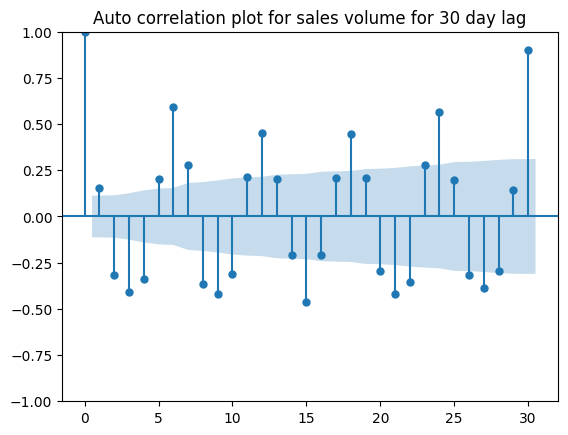

In [28]:
  plot_acf(seasonal_quantity, lags=30)  # Adjust lags as needed
  plt.title(f'Auto correlation plot for sales volume for 30 day lag')
  plt.show()

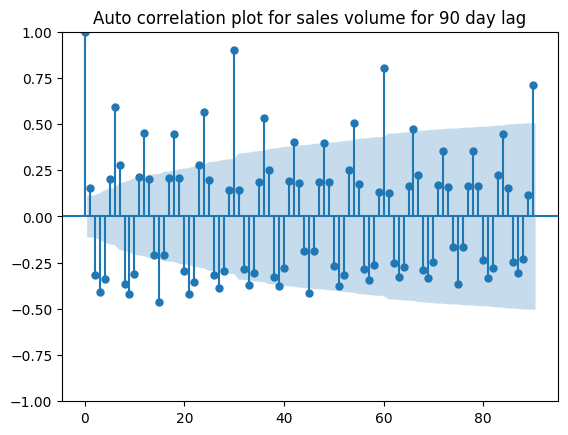

In [29]:
plot_acf(seasonal_quantity, lags=90)  # Adjust lags as needed
plt.title(f'Auto correlation plot for sales volume for 90 day lag')
plt.show()

## **Visualization of other data elements in online sales**


*   Distribution of sales by country - most of sales are in UK
*   Monthly sales - sales are showing are an updward trajectory except in Dec 2012




# **LSTM Model Foecasting**

In [30]:
#setting up the data for LSTM models
def set_up_data(data, look_back):
  X, y = [], []
  for i in range(look_back, len(data)):
    X.append(data[i - look_back:i, 0])
    y.append(data[i, 0])

  X, y = np.array(X), np.array(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series
  # Reshape for LSTM input (samples, timesteps, features)
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  return X_train, X_test, y_train, y_test

## **Sales Revenues Forecasting**




### **LSTM Model with optimal hyperparameters for Sales Revenue Forecasting**


*   Using the optimal hyper parameters trained the model - 30 day look back, 128 units, batch size of 64
*   Generated predictions and calculate RMSE
*   Forecasting accuracy for the optimized model is **63.7%**


*   Plotted the test data and predicted sales revenues





In [31]:
#Optimal Model LSTM Model
optimal_look_back = 30
optimal_units = 128
optimal_batch_size = 64
print("The optimal LSTM Model for Sales Forecast")
print(f'Optimal look_back: {optimal_look_back}')
print(f'Optimal units: {optimal_units}')
print(f'Optimal batch_size: {optimal_batch_size}')

The optimal LSTM Model for Sales Forecast
Optimal look_back: 30
Optimal units: 128
Optimal batch_size: 64


In [32]:
daily_sales = online_retail_data.groupby('FullDate')['SalesDollars'].sum().reset_index()
daily_sales = daily_sales.set_index('FullDate') # Set 'FullDate' as index

In [33]:
sales_data = daily_sales['SalesDollars'].values.reshape(-1, 1)  # Reshape for scaling
# Scale the data
scaler = MinMaxScaler()
sales_data = scaler.fit_transform(sales_data)

In [34]:
X_train, X_test, y_train, y_test=set_up_data(sales_data, optimal_look_back)

In [35]:
optimal_model = Sequential()
optimal_model.add(LSTM(units=optimal_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Adjust units as needed
optimal_model.add(LSTM(units=optimal_units))  # You can add more LSTM layers
optimal_model.add(Dense(1))

In [36]:
optimal_model.compile(loss='mean_squared_error', optimizer='adam')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
y_train = y_train.reshape(-1, 1)

In [37]:
np.random.seed(42)
tf.random.set_seed(42)
optimal_model.fit(X_train, y_train, epochs=100, batch_size=optimal_batch_size,callbacks=[early_stopping], verbose=0)  # Adjust epochs and batch size

In [38]:
predictions = optimal_model.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


In [39]:
optimal_rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE for LSTM model with optimal hyperparameters is  {optimal_rmse}')

RMSE for LSTM model with optimal hyperparameters is  17878.21229751718


In [40]:
sales_dollar_mean = y_test[0].mean()
print(f'Mean value of sales revenues in test data is {sales_dollar_mean}')
forecasting_sales_error= optimal_rmse/sales_dollar_mean
print(f'Forecasting sales error {forecasting_sales_error}')
forecasting_sales_accuracy = 1-forecasting_sales_error
print(f'Forecasting sales revenue accuracy for LSTM model with optimal hyperparameters {forecasting_sales_accuracy}')

Mean value of sales revenues in test data is 49299.98218181817
Forecasting sales error 0.36264135414050236
Forecasting sales revenue accuracy for LSTM model with optimal hyperparameters 0.6373586458594976


In [41]:
test_dates = daily_sales.index[-len(y_test[0]):]

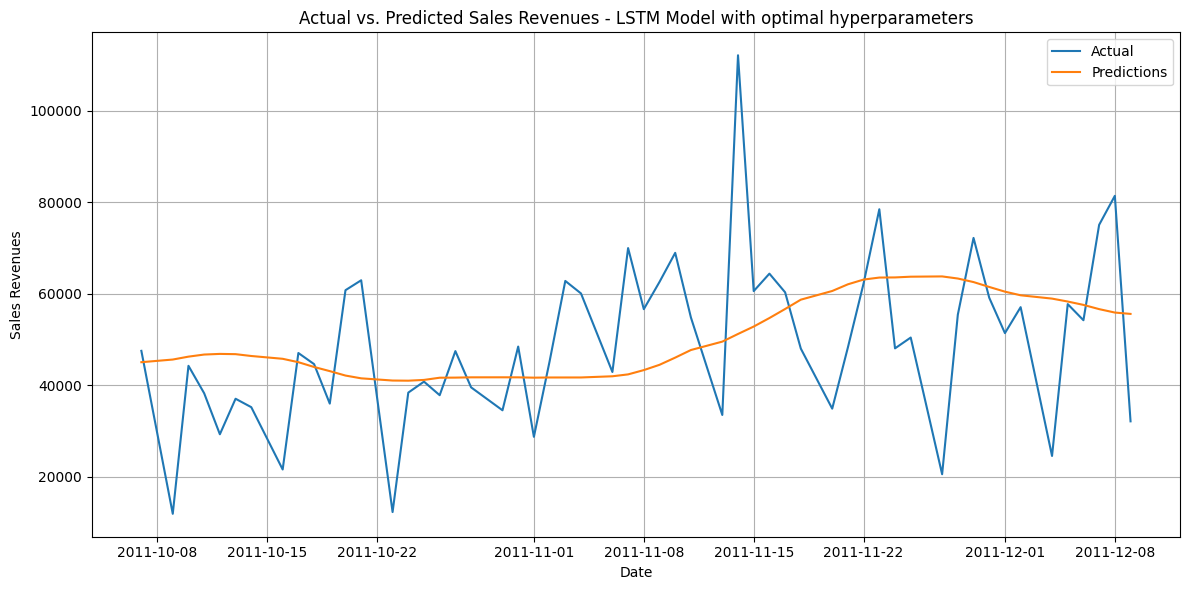

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Revenues')
plt.title('Actual vs. Predicted Sales Revenues - LSTM Model with optimal hyperparameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Bidrectional LSTM Model Forecasting for Sales Volume**

### **Bidrectional LSTM Model with optimal hyperparameters for Sales Volume Forecasting**


*   Using the optimal hyper parameters trained the model - 90 day look back, 128 units, batch size of 64
*   Generated predictions and calculate RMSE
*   Forecasting accuracy for the optimized model is **66.4%**


*   Plotted the test data and predicted sales revenues

In [43]:
daily_quantity = online_retail_data.groupby('FullDate')['Quantity'].sum().reset_index()
daily_quantity = daily_quantity.set_index('FullDate') # Set 'FullDate' as index

In [44]:
quantity_data = daily_quantity['Quantity'].values.reshape(-1, 1)  # Reshape for scaling


In [45]:
scaler = MinMaxScaler()

quantity_data = scaler.fit_transform(quantity_data)


In [46]:
#Optimal Model LSTM Model for Quantity Forecast
optimal_look_back_quants = 90
optimal_units_quants = 128
optimal_batch_size_quants = 64
print("The optimal LSTM Model for Sales Volume Forecast")
print(f'Optimal look_back: {optimal_look_back_quants}')
print(f'Optimal units: {optimal_units_quants}')
print(f'Optimal batch_size: {optimal_batch_size_quants}')

The optimal LSTM Model for Sales Volume Forecast
Optimal look_back: 90
Optimal units: 128
Optimal batch_size: 64


In [47]:
look_back = optimal_look_back_quants  # Number of previous days to consider
X, y = [], []
for i in range(look_back, len(quantity_data)):
    X.append(quantity_data[i - look_back:i, 0])
    y.append(quantity_data[i, 0])

X, y = np.array(X), np.array(y)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series

In [49]:

np.random.seed(42)
tf.random.set_seed(42)
X_train, X_test, y_train, y_test=set_up_data(quantity_data, optimal_look_back_quants)
bi_model_quants = Sequential()
bi_model_quants.add(Bidirectional(LSTM(units=optimal_units_quants, return_sequences=True), input_shape=(X_train.shape[1], 1)))
bi_model_quants.add(Bidirectional(LSTM(units=optimal_units_quants)))
bi_model_quants.add(Dense(1))
bi_model_quants.compile(loss='mean_squared_error', optimizer='adam')
bi_model_quants.fit(X_train, y_train, epochs=100, batch_size=optimal_batch_size, verbose=0)  # Adjust epochs and batch size
predictions_bi_model = bi_model_quants.predict(X_test)

# Inverse transform to get actual sales values
predictions_bi_model = scaler.inverse_transform(predictions_bi_model)
y_test = scaler.inverse_transform([y_test])
bi_quants_rmse = np.sqrt(mean_squared_error(y_test[0], predictions_bi_model))
print(f'RMSE for LSTM bidirectional model for sales volume with optimal hyperparameters is  {bi_quants_rmse}')
print(f'Mean value of sales volume in test data is {y_test[0].mean()}')
sales_volume_mean = y_test[0].mean()
bi_volume_error= bi_quants_rmse/sales_volume_mean
bi_volume_accuracy = 1-bi_volume_error
print(f'Forecasting sales volume accuracy for bidrectional LSTM model with optimal hyperparameters {bi_volume_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
RMSE for LSTM bidirectional model for sales volume with optimal hyperparameters is  8998.53975277021
Mean value of sales volume in test data is 26665.441860465115
Forecasting sales volume accuracy for bidrectional LSTM model with optimal hyperparameters 0.6625392596208323


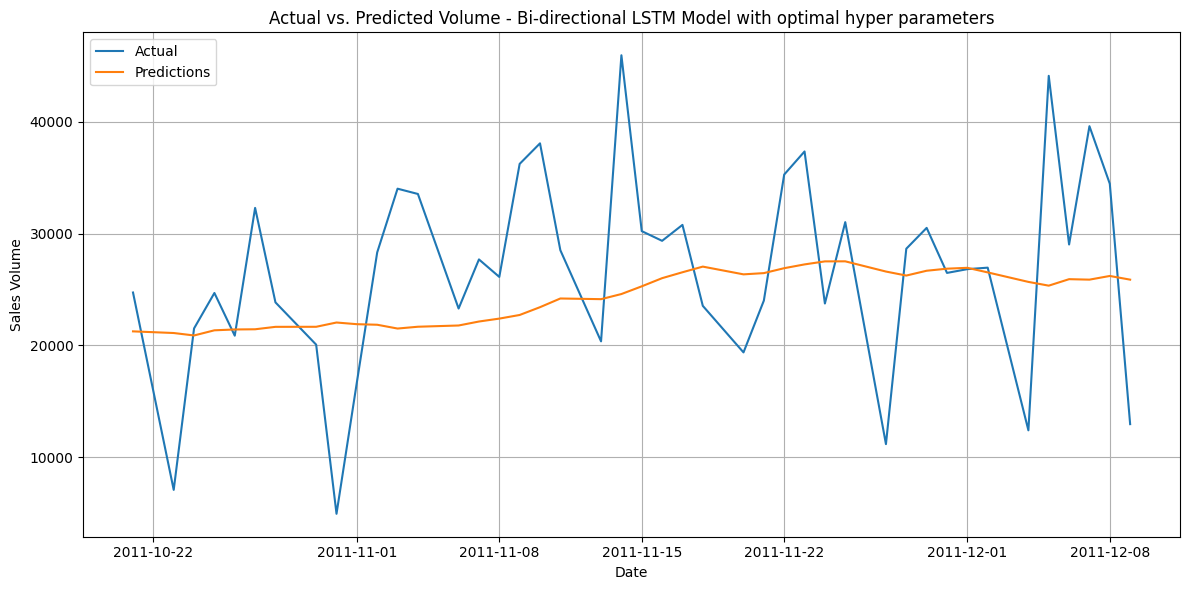

In [50]:
test_dates = daily_quantity.index[-len(y_test[0]):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions_bi_model, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('Actual vs. Predicted Volume - Bi-directional LSTM Model with optimal hyper parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
